In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import requests
from lxml import html

import scipy.interpolate as interp

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcm')
mpl.rcParams['axes.prop_cycle'] = cycler('color', \
                                         ['#1f77b4', '#ff7f0e', '#2ca02c', \
                                          '#d62728', '#9467bd', \
                                          (0.2,0.8,1.), '#bcbd22', '#17becf'])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', \
                '#d62728', '#9467bd', \
                (0.2,0.8,1.), '#bcbd22', '#17becf']


## Code for scraping data from the TENDL web page (no longer used)

In [5]:
# page = requests.get('https://tendl.web.psi.ch/tendl_2019/he3_file/Xe/Xe136/'+\
#                     'tables/xs/xs000100.tot')


# tree = html.fromstring(page.content)

# print(page.text)

# for line in page.text.split('\n'):
#     print(line)


In [6]:
h_residual_path = 'https://tendl.web.psi.ch/tendl_2019/he3_file/Xe/Xe136/tables/residual/'
p_residual_path = 'https://tendl.web.psi.ch/tendl_2019/proton_file/Xe/Xe136/tables/residual/'



# Proton-on-$^{136}$Xe neutron production cross sections

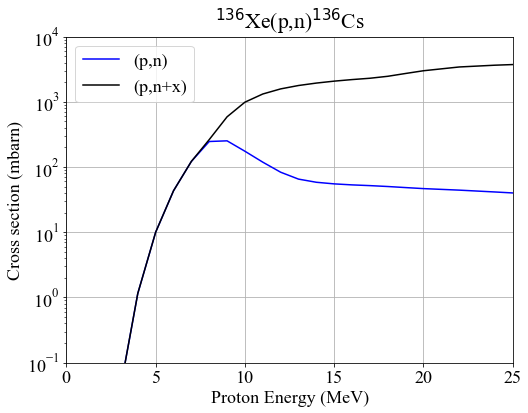

In [41]:
xe136_pn_xsec = np.genfromtxt('../xsec_data/Xe136_pn_xsec.txt',skip_header=5)
xe136_pnx_xsec = np.genfromtxt('../xsec_data/Xe136_pnx_xsec.txt',skip_header=5)
xe136_pgx_xsec = np.genfromtxt('../xsec_data/Xe136_pgx_xsec.txt',skip_header=5)
plt.plot(xe136_pn_xsec[:,0],xe136_pn_xsec[:,1],'-b',label='(p,n)')
plt.plot(xe136_pnx_xsec[:,0],xe136_pnx_xsec[:,1],'-k',label='(p,n+x)')
#plt.plot(xe136_pgx_xsec[:,0],xe136_pgx_xsec[:,1],'-g',label='(p,g+x)')
plt.yscale('log')
plt.ylim(1.e-1,1.e4)
plt.xlim(0.,25.)
plt.ylabel('Cross section (mbarn)')
plt.xlabel('Proton Energy (MeV)')
plt.title('$^{136}$Xe(p,n)$^{136}$Cs')
plt.legend()
plt.grid()



# Calculating interaction rates

In [52]:
f_xe136_pn = interp.interp1d(xe136_pn_xsec[:,0],xe136_pn_xsec[:,1])

def p_per_bunch( current, bunch_period ):
    e = 1.602176634e-19 # C / elementary charge
    particles_per_bunch = current / e * bunch_period
    return particles_per_bunch

In [22]:
beam_current = 5e-9 # Amps
bunch_period = 3.2e-6 # seconds


P = 1. # bar
R = 8.31e-2 # L*bar/(mol*K)
T = 295 # K
M_A = 136 # g/mol
cm3_per_L = 1000
cell_diameter = 0.5 * 2.54 # cm
beam_energy = 7. # MeV


gas_xenon_density = P/(R*T) * 6.02e23 / cm3_per_L # atoms per cm^3



print('Cross section: {:4.4} mbarn'.format(f_xe136_pn(25.)))
print('Gas number density at P = {:2.2} bar: {:3.3} atoms/cm^3\n'.format(P,gas_xenon_density))
print('Gas mass density at P = {:2.2} bar: {:3.3} g/cm^3\n\n'.format(P,gas_xenon_density*136/6e23))




p_n_interactions_per_bunch = f_xe136_pn(beam_energy) * 1e-27 * \
                            cell_diameter * \
                            gas_xenon_density * \
                            p_per_bunch(beam_current,bunch_period)


print('p,n interactions per bunch at {:3.3} MeV: {:4.4}\n\n'.format(\
                    beam_energy, p_n_interactions_per_bunch))




Cross section: 40.07 mbarn
Gas number density at P = 1.0 bar: 2.46e+19 atoms/cm^3

Gas mass density at P = 1.0 bar: 0.00557 g/cm^3


p,n interactions per bunch at 7.0 MeV: 0.3793




## Define function to get probability of multiple interactions

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


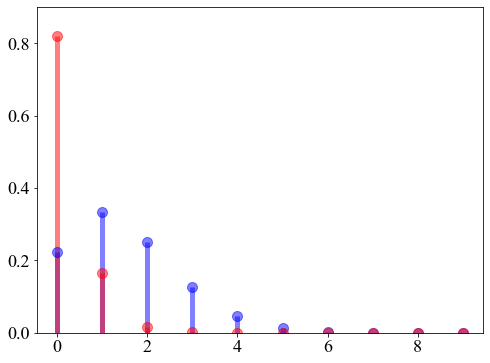

In [47]:
from scipy.stats import poisson

x = np.arange(0.,10.)
print(x)
mu = 1.5
plt.plot(x,poisson.pmf(x,mu),'o',color=(0.,0.,1.,0.5), markersize=10)
plt.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)
plt.ylim(0.,np.max(poisson.pmf(x,mu))*1.1)

mu = 0.2
plt.plot(x,poisson.pmf(x,mu),'o',color=(1.,0.,0.,0.5), markersize=10)
plt.vlines(x, 0, poisson.pmf(x, mu), colors='r', lw=5, alpha=0.5)
plt.ylim(0.,np.max(poisson.pmf(x,mu))*1.1)


def GetProbabilityOfMultiples( mu_array ):
    probs = np.zeros(len(mu_array))
    for i,mu in enumerate(mu_array):
        x = np.arange(0.,30.)
        pois_results = poisson.pmf( x, mu)
        mask = x > 1.
        probs[i] = np.sum( pois_results[mask] )
    return probs


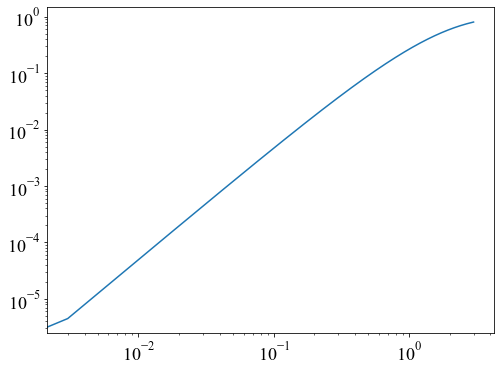

In [51]:
avg = np.linspace(0.,3.,1000)
mult_prob = GetProbabilityOfMultiples(avg)
plt.plot(avg,mult_prob)
plt.xscale('log')
plt.yscale('log')

## Calculation

In [83]:
def p_n_interactions_per_bunch( beam_current = 5., \
                               bunch_period = 3.2, \
                               cell_thickness= 0.5 * 2.54,\
                              beam_energy = 7.):
    # beam_current in nA
    # bunch_period in us
    # cell_thickness in cm
    # beam_energy in MeV
    
    P = 1. # bar
    R = 8.31e-2 # L*bar/(mol*K)
    T = 295 # K
    M_A = 136 # g/mol
    cm3_per_L = 1000
    gas_xenon_density = P/(R*T) * 6.02e23 / cm3_per_L # atoms per cm^3
    
    return f_xe136_pn(beam_energy) * 1e-27 * \
                    cell_thickness * \
                    gas_xenon_density * \
                    p_per_bunch( beam_current*1.e-9, bunch_period*1.e-6)
    

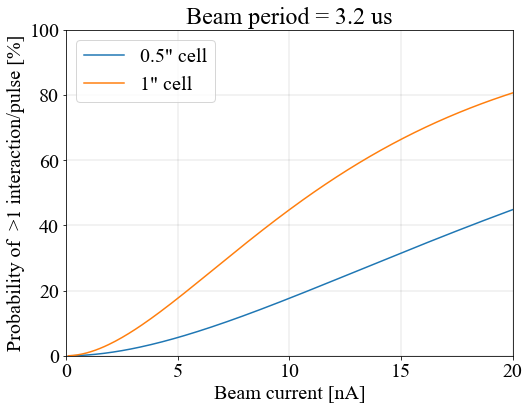

In [91]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (8,6)

beam_current = np.linspace(0.1,20.,200) # nA
# beam_current = np.logspace(-1,np.log10(20.),200)* 1.e-9 # A
bunch_period = 3.2 # us



p_n_per_bunch_0p5in_3p2us = p_n_interactions_per_bunch(beam_current,\
                                                      bunch_period)
mult_prob_0p5in_3p2us = GetProbabilityOfMultiples(p_n_per_bunch_0p5in_3p2us)

p_n_per_bunch_1in_3p2us = p_n_interactions_per_bunch(beam_current,\
                                                      bunch_period,\
                                                    cell_thickness=1.*2.54)
mult_prob_1in_3p2us = GetProbabilityOfMultiples(p_n_per_bunch_1in_3p2us)



plt.plot(beam_current, mult_prob_0p5in_3p2us*100, label='0.5\" cell')
plt.plot(beam_current, mult_prob_1in_3p2us*100, label='1\" cell')
plt.xlim(0.,20.)
plt.ylim(0.,100)
plt.xlabel('Beam current [nA]')
plt.ylabel('Probability of  >1 interaction/pulse [%]')
plt.grid(linewidth=0.1,color=(0.,0.,0.,0.1))
plt.title('Beam period = 3.2 us')
plt.legend(loc='upper left')


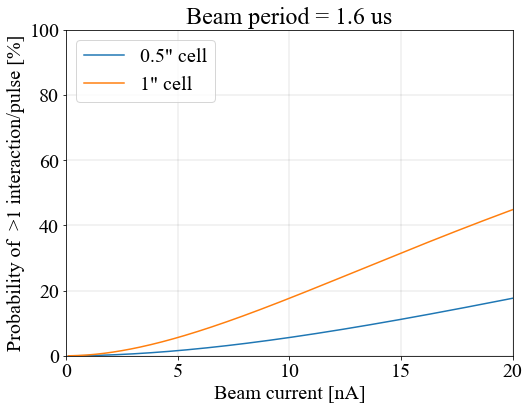

In [92]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (8,6)

beam_current = np.linspace(0.1,20.,200) # nA
# beam_current = np.logspace(-1,np.log10(20.),200)* 1.e-9 # A
bunch_period = 1.6 # us



p_n_per_bunch_0p5in_1p6us = p_n_interactions_per_bunch(beam_current,\
                                                      bunch_period)
mult_prob_0p5in_1p6us = GetProbabilityOfMultiples(p_n_per_bunch_0p5in_1p6us)

p_n_per_bunch_1in_1p6us = p_n_interactions_per_bunch(beam_current,\
                                                      bunch_period,\
                                                    cell_thickness=1.*2.54)
mult_prob_1in_1p6us = GetProbabilityOfMultiples(p_n_per_bunch_1in_1p6us)



plt.plot(beam_current, mult_prob_0p5in_1p6us*100, label='0.5\" cell')
plt.plot(beam_current, mult_prob_1in_1p6us*100, label='1\" cell')
plt.xlim(0.,20.)
plt.ylim(0.,100)
plt.xlabel('Beam current [nA]')
plt.ylabel('Probability of  >1 interaction/pulse [%]')
plt.grid(linewidth=0.1,color=(0.,0.,0.,0.1))
plt.title('Beam period = 1.6 us')
plt.legend(loc='upper left')




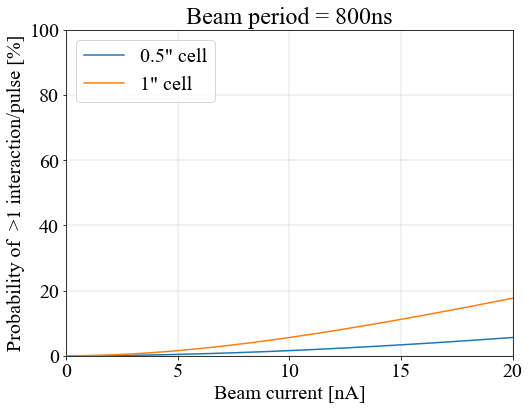

In [93]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (8,6)

beam_current = np.linspace(0.1,20.,200) # nA
# beam_current = np.logspace(-1,np.log10(20.),200)* 1.e-9 # A
bunch_period = 0.8 # us



p_n_per_bunch_0p5in_0p8us = p_n_interactions_per_bunch(beam_current,\
                                                      bunch_period)
mult_prob_0p5in_0p8us = GetProbabilityOfMultiples(p_n_per_bunch_0p5in_0p8us)

p_n_per_bunch_1in_0p8us = p_n_interactions_per_bunch(beam_current,\
                                                      bunch_period,\
                                                    cell_thickness=1.*2.54)
mult_prob_1in_0p8us = GetProbabilityOfMultiples(p_n_per_bunch_1in_0p8us)



plt.plot(beam_current, mult_prob_0p5in_0p8us*100, label='0.5\" cell')
plt.plot(beam_current, mult_prob_1in_0p8us*100, label='1\" cell')
plt.xlim(0.,20.)
plt.ylim(0.,100)
plt.xlabel('Beam current [nA]')
plt.ylabel('Probability of  >1 interaction/pulse [%]')
plt.grid(linewidth=0.1,color=(0.,0.,0.,0.1))
plt.title('Beam period = 800ns')
plt.legend(loc='upper left')



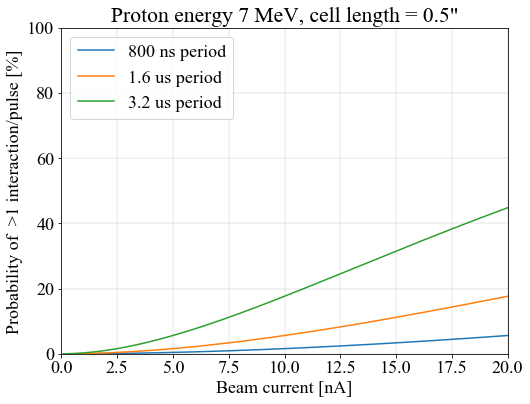

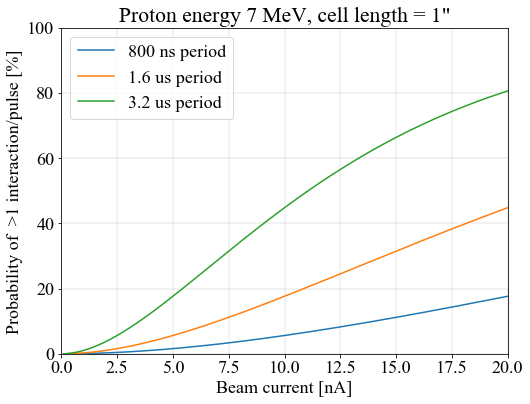

In [100]:


plt.plot(beam_current, mult_prob_0p5in_0p8us*100,\
         '-',color=colors[0],label='800 ns period')
plt.plot(beam_current, mult_prob_0p5in_1p6us*100,\
         '-',color=colors[1],label='1.6 us period')
plt.plot(beam_current, mult_prob_0p5in_3p2us*100,\
         '-',color=colors[2],label='3.2 us period')

plt.xlim(0.,20.)
plt.ylim(0.,100)
plt.xlabel('Beam current [nA]')
plt.ylabel('Probability of  >1 interaction/pulse [%]')
plt.grid(linewidth=0.1,color=(0.,0.,0.,0.1))
plt.legend(loc='upper left')
plt.title('Proton energy 7 MeV, cell length = 0.5\"')
plt.savefig('multiplicity_vs_current_0p5in_cell.png',\
           dpi=300, bbox_inches='tight')



plt.figure(2)
plt.plot(beam_current, mult_prob_1in_0p8us*100,\
         '-',color=colors[0],label='800 ns period')
plt.plot(beam_current, mult_prob_1in_1p6us*100,\
         '-',color=colors[1],label='1.6 us period')
plt.plot(beam_current, mult_prob_1in_3p2us*100,\
         '-',color=colors[2],label='3.2 us period')
plt.xlim(0.,20.)
plt.ylim(0.,100)
plt.xlabel('Beam current [nA]')
plt.ylabel('Probability of  >1 interaction/pulse [%]')
plt.grid(linewidth=0.1,color=(0.,0.,0.,0.1))
plt.legend(loc='upper left')
plt.title('Proton energy 7 MeV, cell length = 1\"')

plt.savefig('multiplicity_vs_current_1in_cell.png',\
           dpi=300, bbox_inches='tight')



